## LOAD LIBRARIES

In [ ]:
# ENVIRONMENT
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import pathlib
from glob import glob

import warnings
warnings.filterwarnings("ignore")

# TENSORFLOW 2.0
import tensorflow as tf
print(tf.__version__)
print('GPU available:', tf.test.is_gpu_available())

from tensorflow.keras.models import Model
from tensorflow.python.keras.layers import Add, BatchNormalization, Conv2D, Dense, Flatten, Input, LeakyReLU, PReLU, Lambda, MaxPool2D, ReLU
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, MeanAbsoluteError, MeanSquaredError
binary_cross_entropy = BinaryCrossentropy()

from tensorflow.keras.metrics import Mean

from tensorflow.keras import backend as K
# from tensorflow import keras
# from keras import backend as K
from tensorflow.python.data.experimental import AUTOTUNE

# ESSENTIAL 
import numpy as np
from sklearn.model_selection import train_test_split
import cv2

# VISUALIZER
import matplotlib.pyplot as plt
plt.ioff()
%matplotlib inline
from IPython import display

# UTILS
import time
import datetime 
from datetime import date
from tqdm import tqdm

In [ ]:
# Setting seed
tf.random.set_seed(11)
np.random.seed(11)

## LOAD DIRECTORIES

```
GAN
│   
└───data
│   │
│   └───real_images
│   │    │  
│   │    └─── transmission
│   │    │  
│   │    └─── blended
│   │
│   └───synthetic_images
│   │    │  
│   │    └─── transmission
│   │    │  
│   │    └─── reflection
│   │    │  
│   │    └─── synthetic
│   │    │  
│   │    └─── mask (reflection mask created from synthetic generation)
│   │
│   └───test
│        │  
│        └─── transmission
│        │  
│        └─── blended
│   
└───logs
    │
    └─── ckpts 
    │    │  
    │    │  
    │    └─── train 
    │
    └─── output
         │  
         │  
         └─── train 

```

In [ ]:
pwd

In [ ]:
# Dataset Directories
DATA_DIR = "./data"

BLENDED_TRAIN_DIR      = os.path.join(DATA_DIR, 'real_images/blended')    
TRANSMISSION_TRAIN_DIR = os.path.join(DATA_DIR, 'real_images/transmission')

SYN_REFLECTION_TRAIN_DIR   = os.path.join(DATA_DIR, 'synthetic_images/reflection')
SYN_TRANSMISSION_TRAIN_DIR = os.path.join(DATA_DIR, 'synthetic_images/transmission')
SYN_TRAIN_DIR = os.path.join(DATA_DIR, 'synthetic_images/synthetic')
SYN_MASK_DIR  = os.path.join(DATA_DIR, 'synthetic_images/mask')


BLENDED_TEST_DIR = os.path.join(DATA_DIR, 'test/blended')    
TRANSMISSION_TEST_DIR = os.path.join(DATA_DIR, 'test/transmission')

# Training Support Directories 
LOG_DIR = './logs'

CKPTS_DIR  = os.path.join(LOG_DIR, 'ckpts')
OUTPUT_DIR = os.path.join(LOG_DIR, 'output')

In [ ]:
TRAIN_CKPTS_DIR = os.path.join(CKPTS_DIR, 'train')
# PRETR_CKPTS_DIR = os.path.join(CKPTS_DIR, 'pretrain')

## PREPARE DATASET

### Configuration

In [ ]:
## Image Configuration
CHANNEL = 3
IMG_WIDTH = 128
IMG_HEIGHT = 128

# Following research paper, hypercolumn feature from VGG layers has 1472 dimensions in total,
# concat to image(x,x,3) for Generator 
INPUT_SIZE = (None, None, 1475)

# Training Configuration 
BATCH_SIZE = 1 
BUFFER_SIZE = 400

GAN_GEN_LR = 2e-4
GAN_DIS_LR = 1e-4
OPT_BETA_1 = 0.5

EPS = 1e-12

CKPT_SAVE = 2

### Load & Pre-process Data

In [ ]:
def load_paths_from_directory(directory, format_type='jpeg'):
    return sorted(glob(os.path.join(directory, "*.{}".format(format_type))))

In [ ]:
def load_image(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image, channels= 3)
    
    input_image = tf.cast(image, tf.float32)
    
    return input_image

#### Pre-process for real data

In [ ]:
def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width], 
                                  method= tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                                 method= tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    return input_image, real_image

In [ ]:
# def random_crop(input_image, real_image):
    
#     new_w = tf.random.uniform(shape=(), minval= CROP_SIZE[0], maxval= CROP_SIZE[1], dtype=tf.int32)
#     new_h = new_w
    
#     stacked_image = tf.stack([input_image, real_image], axis=0)
#     cropped_image = tf.image.random_crop(stacked_image, 
#                                          size=[2, new_w, new_h, 3])
    
#     return cropped_image[0], cropped_image[1]

In [ ]:
# normalizing the images 
def normalize(input_image, real_image):
    input_img = input_image / 255.
    real_img =  real_image / 255.

    return input_img, real_img

#### Pre-process for synthetic data

In [ ]:
def resize_syn(input_image, real_image, mask_image, height, width):
    input_image = tf.image.resize(input_image, [height, width], 
                                  method= tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                                 method= tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    mask_image = tf.image.resize(mask_image, [height, width],
                                 method= tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return input_image, real_image, mask_image

In [ ]:
# normalizing the images 
def normalize_syn(input_image, real_image, mask_image):
    input_image = input_image / 255.
    real_image =  real_image / 255.
    mask_image =  mask_image / 255.

    return input_image, real_image, mask_image

### Load & process images for tf Data set

#### For real data

In [ ]:
def load_image_train(image_input_train, image_target_train):
    input_image = load_image(image_input_train)
    real_image = load_image(image_target_train)
#     # Random crop images
#     input_image, real_image = random_crop(input_image, real_image)
    
    # Resize images 
    input_image, real_image = resize(input_image, real_image, IMG_WIDTH, IMG_HEIGHT)
    
#    # Random resize
#     input_image, real_image = random_resize(input_image, real_image)

    input_image, real_image = normalize(input_image, real_image)
  
    return input_image, real_image

#### For synthetic data

In [ ]:
def load_image_train_syn(image_input_train, image_target_train, mask_train):
    input_image = load_image(image_input_train)
    real_image  = load_image(image_target_train)
    mask_image  = load_image(mask_train)
    
#     # Random crop images
#     input_image, real_image = random_crop(input_image, real_image)
    
    # Resize images 
    input_image, real_image, mask_image = resize_syn(input_image, real_image, mask_image, IMG_WIDTH, IMG_HEIGHT)
    
#    # Random resize
#     input_image, real_image = random_resize(input_image, real_image)

    input_image, real_image, mask_image = normalize_syn(input_image, real_image, mask_image)
  
    return input_image, real_image, mask_image

#### For test data

In [ ]:
def load_image_test(image_input_test, image_target_test):
    input_image = load_image(image_input_test)
    real_image = load_image(image_target_test)
    input_image, real_image = resize(input_image, real_image, IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)
  
    return input_image, real_image

## Get features from layers of VGG19 pretrained model

##### Load from matrix

In [ ]:
import scipy.io
import scipy.stats as st

vgg_path= scipy.io.loadmat('./imagenet-vgg-verydeep-19.mat')
vgg_layers=vgg_path['layers'][0]

In [ ]:
# @tf.function
def build_conv(net_in, net_weight_bias= None, name= None):
    return tf.nn.relu(tf.nn.conv2d(net_in, net_weight_bias[0], 
                                   strides=[1,1,1,1], 
                                   padding='SAME', name=name) + net_weight_bias[1] )

# @tf.function
def build_pool(net_in):
    return tf.nn.avg_pool(net_in, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

In [ ]:
# @tf.function
def get_weight_bias(i):
    weights = vgg_layers[i][0][0][2][0][0]
    weights = tf.constant(weights)
    bias = vgg_layers[i][0][0][2][0][1]
    bias = tf.constant(np.reshape(bias,(bias.size)))
    return weights,bias

In [ ]:
# VGG means array
vgg_mean = tf.convert_to_tensor(np.array([123.6800, 116.7790, 103.9390]).reshape((1,1,1,3)), dtype='float32')

In [ ]:
# build VGG19 to load pre-trained parameters
def build_vgg19(inp):
        net={}
        
#         net['input']= inp - vgg_mean
        net['input']= tf.add(inp, -vgg_mean)

        net['conv1_1']= build_conv(net['input'],get_weight_bias(0),name='vgg_conv1_1')
        net['conv1_2']= build_conv(net['conv1_1'],get_weight_bias(2),name='vgg_conv1_2')
        net['pool1']= build_pool(net['conv1_2'])
        net['conv2_1']= build_conv(net['pool1'],get_weight_bias(5),name='vgg_conv2_1')
        net['conv2_2']= build_conv(net['conv2_1'],get_weight_bias(7),name='vgg_conv2_2')
        net['pool2']= build_pool(net['conv2_2'])
        net['conv3_1']= build_conv(net['pool2'],get_weight_bias(10),name='vgg_conv3_1')
        net['conv3_2']= build_conv(net['conv3_1'],get_weight_bias(12),name='vgg_conv3_2')
        net['conv3_3']= build_conv(net['conv3_2'],get_weight_bias(14),name='vgg_conv3_3')
        net['conv3_4']= build_conv(net['conv3_3'],get_weight_bias(16),name='vgg_conv3_4')
        net['pool3']= build_pool(net['conv3_4'])
        net['conv4_1']= build_conv(net['pool3'],get_weight_bias(19),name='vgg_conv4_1')
        net['conv4_2']= build_conv(net['conv4_1'],get_weight_bias(21),name='vgg_conv4_2')
        net['conv4_3']= build_conv(net['conv4_2'],get_weight_bias(23),name='vgg_conv4_3')
        net['conv4_4']= build_conv(net['conv4_3'],get_weight_bias(25),name='vgg_conv4_4')
        net['pool4']= build_pool(net['conv4_4'])
        net['conv5_1']= build_conv(net['pool4'],get_weight_bias(28),name='vgg_conv5_1')
        net['conv5_2']= build_conv(net['conv5_1'],get_weight_bias(30),name='vgg_conv5_2')
        return net

In [ ]:
def get_new_vgg_features(inp_img, target, test= False):
    vgg19_features= build_vgg19(inp_img[:,:,:,0:3]*255.0)   
    inp_features = tf.identity(inp_img)
    if test:
        for layer_id in range(1,6):
            vgg19_f = vgg19_features['conv%d_2'%layer_id] 
            inp_features = tf.concat([tf.image.resize(tf.zeros_like(vgg19_f), (tf.shape(inp_features)[1], tf.shape(inp_features)[2]),
                                             method=tf.image.ResizeMethod.BILINEAR)/255.0, inp_features], axis=3)
    else:    
        for layer_id in range(1,6):
            vgg19_f = vgg19_features['conv%d_2'%layer_id] 
            inp_features = tf.concat([tf.image.resize(vgg19_f, (tf.shape(inp_features)[1],tf.shape(inp_features)[2]),
                                             method=tf.image.ResizeMethod.BILINEAR)/255.0, inp_features], axis=3)
    return inp_img, inp_features, target

##### function for synthetic images

In [ ]:
def get_new_vgg_features_syn(inp_img, target, mask, test= False):
    vgg19_features= build_vgg19(inp_img[:,:,:,0:3]*255.0)   
    inp_features = tf.identity(inp_img)
    if test:
        for layer_id in range(1,6):
            vgg19_f = vgg19_features['conv%d_2'%layer_id] 
            inp_features = tf.concat([tf.image.resize(tf.zeros_like(vgg19_f), (tf.shape(inp_features)[1], tf.shape(inp_features)[2]),
                                             method=tf.image.ResizeMethod.BILINEAR)/255.0, inp_features], axis=3)
    else:    
        for layer_id in range(1,6):
            vgg19_f = vgg19_features['conv%d_2'%layer_id] 
            inp_features = tf.concat([tf.image.resize(vgg19_f, (tf.shape(inp_features)[1],tf.shape(inp_features)[2]),
                                             method=tf.image.ResizeMethod.BILINEAR)/255.0, inp_features], axis=3)
    return inp_img, inp_features, target, mask

##### NEW VGG19 Feature Extraction Model (use keras pretrained Model)

In [ ]:
# # Pre-trained VGG 
# from tensorflow.python.keras.applications.vgg19 import VGG19
# vgg_19 = VGG19(input_shape=(None, None, 3), weights='imagenet', include_top=False)

# Do we need setting trainable = False?

In [ ]:
# new_vgg_18 = Model(inputs = vgg_19.input,
#                    outputs = [vgg_19.layers[0].output,       #Outout of Input layer
#                               vgg_19.layers[2].output,       #Conv1_2
#                               vgg_19.layers[5].output,       #Conv2_2
#                               vgg_19.layers[8].output,       #Conv3_2
#                               vgg_19.layers[13].output,      #Conv4_2
#                               vgg_19.layers[18].output])     #Conv5_2

In [ ]:
# vgg_mean = [103.939, 116.779, 123.68]

# def preprocess_vgg(inp):
#     input_img = tf.cast(inp * 255, dtype=tf.float32)
#     r,g,b = tf.split(inp, 3, 3)
#     bgr = tf.concat([b-vgg_mean[0],
#                      g-vgg_mean[1],
#                      r-vgg_mean[2]], axis=3)
    
#     return bgr

In [ ]:
# def get_new_vgg_features(inp_img, target, test= False):
# #     inp_process = preprocess_vgg(inp_img)
# #     vgg19_features = new_vgg_18(inp_process)
#     vgg19_features = new_vgg_18(preprocess_vgg(inp_img))
    
#     inp_features = tf.identity(inp_img)
#     if test:
#         for layer_id in range(1,6):
#             vgg19_f = vgg19_features[layer_id] 
#             inp_features = tf.concat([tf.image.resize(tf.zeros_like(vgg19_f), (tf.shape(inp_features)[1], tf.shape(inp_features)[2]),
#                                              method=tf.image.ResizeMethod.BILINEAR)/255.0, inp_features], axis=3)
#     else:    
#         for layer_id in range(1,6):
#             vgg19_f = vgg19_features[layer_id] 
#             inp_features = tf.concat([tf.image.resize(vgg19_f, (tf.shape(inp_features)[1],tf.shape(inp_features)[2]),
#                                              method=tf.image.ResizeMethod.BILINEAR)/255.0, inp_features], axis=3)
#     return inp_img, inp_features, target

##### function for synthetic images

In [ ]:
# def get_new_vgg_features_syn(inp_img, target, mask, test= False):
# #     inp_process = preprocess_vgg(inp_img)
# #     vgg19_features = new_vgg_18(inp_process)
#     vgg19_features = new_vgg_18(preprocess_vgg(inp_img))
    
#     inp_features = tf.identity(inp_img)
#     if test:
#         for layer_id in range(1,6):
#             vgg19_f = vgg19_features[layer_id] 
#             inp_features = tf.concat([tf.image.resize(tf.zeros_like(vgg19_f), (tf.shape(inp_features)[1], tf.shape(inp_features)[2]),
#                                              method=tf.image.ResizeMethod.BILINEAR)/255.0, inp_features], axis=3)
#     else:    
#         for layer_id in range(1,6):
#             vgg19_f = vgg19_features[layer_id] 
#             inp_features = tf.concat([tf.image.resize(vgg19_f, (tf.shape(inp_features)[1],tf.shape(inp_features)[2]),
#                                              method=tf.image.ResizeMethod.BILINEAR)/255.0, inp_features], axis=3)
#     return inp_img, inp_features, target, mask

### Input Pipeline

In [ ]:
input_train_paths  = load_paths_from_directory(BLENDED_TRAIN_DIR)      #load_paths_from_directory_jpeg(BLENDED_TRAIN_DIR)
target_train_paths = load_paths_from_directory(TRANSMISSION_TRAIN_DIR) #load_paths_from_directory_jpeg(TRANSMISSION_TRAIN_DIR)

assert len(input_train_paths) == len(target_train_paths)
num_train = len(target_train_paths)

In [ ]:
syn_input_train_paths = load_paths_from_directory(SYN_TRAIN_DIR, 'jpg')  
mask_train_paths      = load_paths_from_directory(SYN_MASK_DIR, 'jpg')

syn_target_train_paths = []

for path in syn_input_train_paths:
    _path_trans = os.path.join(SYN_TRANSMISSION_TRAIN_DIR, os.path.split(path)[1])
    syn_target_train_paths.append(_path_trans)        
        
assert len(syn_input_train_paths) == len(syn_target_train_paths)
assert len(syn_input_train_paths) == len(mask_train_paths)
num_train_syn = len(syn_target_train_paths)

In [ ]:
input_test_paths  = load_paths_from_directory(BLENDED_TEST_DIR, 'jpg')       #load_paths_from_directory_jpg(BLENDED_TEST_DIR)
target_test_paths = load_paths_from_directory(TRANSMISSION_TEST_DIR, 'jpg')  #load_paths_from_directory_jpg(TRANSMISSION_TEST_DIR)

assert len(input_test_paths) == len(target_test_paths)
num_test = len(target_test_paths)

In [ ]:
num_train, num_train_syn, num_test

Add more data to train set (for real data set training only)

In [ ]:
# len(input_test_paths)

In [ ]:
for path in input_test_paths[: len(input_test_paths)//2]:
    input_train_paths.append(path)
for path in target_test_paths[: len(target_test_paths)//2]:  
    target_train_paths.append(path)

assert len(input_train_paths) == len(target_train_paths)
num_train = len(target_train_paths)

### Load TF-dataset

##### Train dataset for real images

In [ ]:
BUFFER_SIZE = num_train

train_dataset = tf.data.Dataset.from_tensor_slices((input_train_paths, target_train_paths))
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls= AUTOTUNE)
train_dataset = train_dataset.cache()
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.map(get_new_vgg_features,
                                  num_parallel_calls= AUTOTUNE)
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

##### Train dataset for synthetic images

In [ ]:
BUFFER_SIZE = num_train_syn

train_syn_dataset = tf.data.Dataset.from_tensor_slices((syn_input_train_paths, syn_target_train_paths, mask_train_paths))
train_syn_dataset = train_syn_dataset.shuffle(BUFFER_SIZE)
train_syn_dataset = train_syn_dataset.map(load_image_train_syn,
                                          num_parallel_calls= AUTOTUNE)
train_syn_dataset = train_syn_dataset.cache()
train_syn_dataset = train_syn_dataset.batch(BATCH_SIZE)
train_syn_dataset = train_syn_dataset.map(get_new_vgg_features_syn,
                                          num_parallel_calls= AUTOTUNE)
train_syn_dataset = train_syn_dataset.prefetch(buffer_size=AUTOTUNE)

##### Test dataset

In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((input_test_paths, target_test_paths))

test_dataset = test_dataset.map(load_image_test, num_parallel_calls= AUTOTUNE)
# test_dataset = test_dataset.map(get_new_vgg_features(test= True), num_parallel_calls= AUTOTUNE)
# test_dataset = test_dataset.cache()
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

-----------------------------------

### Load Examples

In [ ]:
# blended_img = load_image(input_test_paths[0])
# target_img  = load_image(target_test_paths[0])

# plt.figure(figsize=(15, 12))
# plt.subplot(121)
# plt.imshow(blended_img)
# plt.subplot(122)
# plt.imshow(target_img)
# plt.show()

In [ ]:
# Process image to test function 
# blended_img_4dim = tf.expand_dims(blended_img, axis=0)

## VISUALIZATION UTILITIES

Load images from test set during training to check

In [ ]:
def generate_images(model, test_input, tar, epoch= 0):
#     prediction_features = process_gen_input(test_input, test=True)
    if epoch % 2 == 0:
        _, prediction_features, _ = get_new_vgg_features(test_input, target=None, test=True)

        prediction = model(prediction_features, training= True)
        prediction_transmission, prediction_reflection = tf.split(prediction, num_or_size_splits=2, axis=3) 

        fig = plt.figure(figsize=(15,15))

        display_list = [test_input[0], tar[0], prediction_transmission[0]]
        title = ['Input Image', 'Ground Truth', 'Predicted Image']

        for i in range(3):
            plt.subplot(1, 3, i+1)
            plt.title(title[i])
            plt.imshow(display_list[i]) 
            plt.axis('off')
        plt.show()

#         # Save image
#         if ((epoch ) % CKPT_SAVE) == 0:
#             fig_path = os.path.join(OUTPUT_DIR, 'train', 'fig_at_epoch_{:03d}.png'.format(epoch))
#             plt.savefig(fig_path)
#             plt.close(fig)
        
#         img_path = os.path.join(OUTPUT_DIR, 'train', 'img_at_epoch_{:03d}.png'.format(epoch))
#         plt.imsave(img_path, display_list[2])

## MODEL

### Generator

In [ ]:
# GENERATOR (aka model to train for Reflection Removal)
class Generator(object):
    def __init__(self):
        self.n_filters = 64
        self.channels = 3
#         self.initializer = tf.initializers.he_normal(seed=None)
#         self.initializer = tf.keras.initializers.Identity(gain= 1.0)
    
    def identity_initializer(self):
        def _initializer(shape, dtype=tf.float64, partition_info=None):
            array = np.zeros(shape, dtype=float)
            cx, cy = shape[0]//2, shape[1]//2
            for i in range(np.minimum(shape[2],shape[3])):
                array[cx, cy, i, i] = 1
            return tf.constant(array, dtype=dtype)
        return _initializer

    def activation_normalizer(self, layer):
        layer = tf.keras.layers.LeakyReLU(0.2)(layer)
        layer = tf.keras.layers.BatchNormalization()(layer)
        return layer
    
    def build_gen(self, input_shape):
        
        inp = tf.keras.layers.Input(shape = input_shape)

        gen = tf.keras.layers.Conv2D(filters= 64, kernel_size= [1,1], dilation_rate= 1, padding= 'same',
                                     kernel_initializer= self.identity_initializer())(inp)
        gen = self.activation_normalizer(gen)

        gen = tf.keras.layers.Conv2D(64, kernel_size= [3,3], dilation_rate= 1, padding= 'same', 
                                     kernel_initializer= self.identity_initializer())(gen)
        gen = self.activation_normalizer(gen)

        gen = tf.keras.layers.Conv2D(64, kernel_size= [3,3], dilation_rate= 2, padding= 'same', 
                                     kernel_initializer= self.identity_initializer())(gen)
        gen = self.activation_normalizer(gen)

        gen = tf.keras.layers.Conv2D(64, kernel_size= [3,3], dilation_rate= 4, padding= 'same', 
                                     kernel_initializer= self.identity_initializer())(gen)
        gen = self.activation_normalizer(gen)

        gen = tf.keras.layers.Conv2D(64, kernel_size= [3,3], dilation_rate= 8, padding= 'same', 
                                     kernel_initializer= self.identity_initializer())(gen)
        gen = self.activation_normalizer(gen)

        gen = tf.keras.layers.Conv2D(64, kernel_size= [3,3], dilation_rate= 16, padding= 'same', 
                                     kernel_initializer= self.identity_initializer())(gen)
        gen = self.activation_normalizer(gen)

        gen = tf.keras.layers.Conv2D(64, kernel_size= [3,3], dilation_rate= 32, padding= 'same', 
                                     kernel_initializer= self.identity_initializer())(gen)
        gen = self.activation_normalizer(gen)

        gen = tf.keras.layers.Conv2D(64, kernel_size= [3,3], dilation_rate= 64, padding= 'same', 
                                     kernel_initializer= self.identity_initializer())(gen)
        gen = self.activation_normalizer(gen)

        gen = tf.keras.layers.Conv2D(64, kernel_size= [3,3], dilation_rate= 1, padding= 'same', 
                                     kernel_initializer= self.identity_initializer())(gen)
        gen = self.activation_normalizer(gen)
        
        # last layer
        gen = tf.keras.layers.Conv2D(6, kernel_size= [1,1], dilation_rate= 1, padding= 'same')(gen)
        gen = Model(inp, gen)
        
        return gen

### Discriminator

In [ ]:
# DISCRIMINATOR
class Discriminator(object):
    def __init__(self):
        self.filters = 64
#         self.init_kernel = tf.initializers.he_normal(seed= None)
        self.init_kernel = tf.random_normal_initializer(0., 0.02)
    
    def lrelu(self, x_in, a):
        x = tf.identity(x_in)
        return (0.5 * (1 + a)) * x + (0.5 * (1 - a)) * tf.abs(x)
    
    def batchnorm(self, x_in):
        # this block looks like it has 3 inputs on the graph unless we do this
        in_layer = tf.identity(x_in)

        channels = in_layer.get_shape()[3]  
#         offset = tf.Variable(initial_value= tf.zeros_initializer(), dtype= tf.float32, trainable= False, shape= [channels],name= 'offset')
#         scale = tf.Variable(initial_value= tf.random_normal_initializer(1.0, 0.02), dtype= tf.float32, trainable= False, shape= [channels],name= 'scale')
        
        offset = tf.compat.v1.get_variable("offset", [channels], dtype=tf.float64, initializer=tf.zeros_initializer())
        scale = tf.compat.v1.get_variable("scale", [channels], dtype=tf.float64, initializer=tf.random_normal_initializer(1.0, 0.02))       
        mean, variance = tf.nn.moments(in_layer, axes=[0, 1, 2], keepdims=False)
        variance_epsilon = 1e-5
            
        normalized = tf.nn.batch_normalization(in_layer, mean, variance, offset, scale, variance_epsilon= variance_epsilon)
        
        return normalized    
    
    
    def conv_block(self, x_in, filters, strides, batch_norm= True, relu_act= True):
        x_in = tf.pad(x_in, [[0, 0], [1, 1], [1, 1], [0, 0]], mode="CONSTANT")
        # x = tf.keras.layers.Lambda(lambda x: tf.pad(x_in, [[0, 0], [1, 1], [1, 1], [0, 0]], mode="CONSTANT"))

        x = tf.keras.layers.Conv2D(filters= filters, kernel_size= 4,
                                   strides= strides, use_bias= False, 
                                   padding="VALID",
                                  #  padding="SAME", 
                                   kernel_initializer= self.init_kernel)(x_in)
                                  #  kernel_initializer= self.initializer)(x_in)
        if batch_norm:
            x = BatchNormalization()(x)
#             x = self.batchnorm(x)
            
        if relu_act:
            x = self.lrelu(x, 0.2)
#             x = LeakyReLU(0.2)(x)
        return x

    def build_discriminator(self, input_shape):
        inp = tf.keras.layers.Input(shape=input_shape, name='input_image')
        tar = tf.keras.layers.Input(shape=input_shape, name='target_image')

        x_in = tf.keras.layers.concatenate([inp, tar])
        
        # Discriminator Layers:     
        x = self.conv_block(x_in, self.filters, 2, False)  #Layer 1, filters = 64        
        
        x = self.conv_block(x, self.filters *2, 2) #Layer 2, filters = 128
        x = self.conv_block(x, self.filters *4, 2) #Layer 3, filters = 256
        x = self.conv_block(x, self.filters *8, 1) #Layer 4, filters = 512  
        x = self.conv_block(x, 1, 1, False, False) #Layer 5
        
        # Last layer
        x = tf.keras.activations.sigmoid(x)
#         x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

        x = Model(inputs= [inp, tar], outputs= x)
        return x


In [ ]:
# discriminator = Discriminator().build_discriminator(input_shape= (IMG_WIDTH, IMG_HEIGHT, 3))

In [ ]:
# discriminator.summary()

### Loss functions

In [ ]:
# Loss functions to use
# L1 loss
# @tf.function
def compute_l1_loss(in_img, out_img):
    ''' Compute L1 loss
    '''
    return tf.reduce_mean(tf.abs(in_img - out_img))

# #Perceptual loss
@tf.function
def _perceptual_loss(gen_img, target_img):
    # Loss using matrix weights
    vgg_real= build_vgg19(target_img*255.0)
    vgg_fake= build_vgg19(gen_img*255.0)
    
    p0= compute_l1_loss(vgg_real['input'],vgg_fake['input'])
    p1= compute_l1_loss(vgg_real['conv1_2'],vgg_fake['conv1_2']) /2.6
    p2= compute_l1_loss(vgg_real['conv2_2'],vgg_fake['conv2_2']) /4.8
    p3= compute_l1_loss(vgg_real['conv3_2'],vgg_fake['conv3_2']) /3.7
    p4= compute_l1_loss(vgg_real['conv4_2'],vgg_fake['conv4_2']) /5.6
    p5= compute_l1_loss(vgg_real['conv5_2'],vgg_fake['conv5_2']) *10/1.5

    # Perceptual loss with new_vgg_18 
#     target_img = preprocess_vgg(target_img)
#     gen_img = preprocess_vgg(gen_img)
    
#     vgg_real = new_vgg_18(target_img) 
#     vgg_fake = new_vgg_18(gen_img) 
    
#     p0 = compute_l1_loss(vgg_real[0], vgg_fake[0])
#     p1 = compute_l1_loss(vgg_real[1], vgg_fake[1]) /2.6
#     p2 = compute_l1_loss(vgg_real[2], vgg_fake[2]) /4.8
#     p3 = compute_l1_loss(vgg_real[3], vgg_fake[3]) /3.7
#     p4 = compute_l1_loss(vgg_real[4], vgg_fake[4]) /5.6
#     p5 = compute_l1_loss(vgg_real[5], vgg_fake[5]) *10/1.5    

    return p0+p1+p2+p3+p4+p5

In [ ]:
# Exclusion loss, in gradient domain  
# FLAG, if using synthetic images, use this loss
def compute_gradient(img):
    gradx = img[:,1:,:,:] - img[:,:-1,:,:]
    grady = img[:,:,1:,:] - img[:,:,:-1,:]
    return gradx, grady

# img1: transmission layer, img2: reflection layer
def _exclusion_loss(img1, img2, level=1):
    gradx_loss=[]
    grady_loss=[]
    
    for l in range(level):
        gradx1, grady1=compute_gradient(img1)
        gradx2, grady2=compute_gradient(img2)
        alphax=2.0*tf.reduce_mean(tf.abs(gradx1))/tf.reduce_mean(tf.abs(gradx2))
        alphay=2.0*tf.reduce_mean(tf.abs(grady1))/tf.reduce_mean(tf.abs(grady2))
        
        gradx1_s=(tf.nn.sigmoid(gradx1)*2)-1
        grady1_s=(tf.nn.sigmoid(grady1)*2)-1
        gradx2_s=(tf.nn.sigmoid(gradx2*alphax)*2)-1
        grady2_s=(tf.nn.sigmoid(grady2*alphay)*2)-1

        gradx_loss.append(tf.reduce_mean(tf.multiply(tf.square(gradx1_s),tf.square(gradx2_s)), axis= [1,2,3])**0.25)
        grady_loss.append(tf.reduce_mean(tf.multiply(tf.square(grady1_s),tf.square(grady2_s)), axis= [1,2,3])**0.25)

        img1=tf.nn.avg_pool(img1, [1,2,2,1], [1,2,2,1], padding='SAME')
        img2=tf.nn.avg_pool(img2, [1,2,2,1], [1,2,2,1], padding='SAME')
    return gradx_loss, grady_loss

def _gradient_loss(gen_img, refl_img):
    loss_gradx, loss_grady = _exclusion_loss(gen_img, refl_img, level=3)
    loss_gradxy = tf.reduce_sum(sum(loss_gradx) /3.) + tf.reduce_sum(sum(loss_grady) /3.)
    
    # If is synthetic, grad_loss = loss_gradxy/2, else 0 (loss_grad = tf.where(issyn, loss_gradxy/2.0, 0) )
    # loss_grad = loss_gradxy / 2.0
    loss_grad = loss_gradxy / 2.0
    return loss_grad

In [ ]:
# # Adversarial Loss (aka Generator loss & Discriminator loss)
# EPS = 1e-12
# @tf.function
def _adversarial_loss(disc_real_out, disc_gen_out):
    ''' Compute generator loss and discriminator loss
    '''
    gen_loss = tf.reduce_mean(-tf.math.log(disc_gen_out + EPS))
    disc_loss = tf.reduce_mean( -( tf.math.log(disc_real_out + EPS) + tf.math.log1p(-disc_gen_out + EPS) ) ) * 0.5
    
    return gen_loss, disc_loss

## METRICS

Use PSNR (Peak Signal-to-noise Ratio) as the metrics for this project. 

PSNR is most easily defined via the mean squared error (MSE). Given a noise-free m×n monochrome image I and its noisy approximation K, MSE is defined as:

![alt text](https://i.imgur.com/IqDUF3d.png)

![](https://ni.scene7.com/is/image/ni/PSNR_MATH?scl=1)

In [ ]:
def resolve(model, in_img):
    """ Predict a batch
        and convert them to readable images.
    """
    in_img = tf.cast(in_img, tf.float32)
    _, prediction_features, _ = get_new_vgg_features(in_img, target=None, test=True)

    out_img = model(prediction_features)
    out_transmission, out_reflection = tf.split(out_img, num_or_size_splits=2, axis=3)
   
    return out_transmission
     
def psnr(x1, x2):
    return tf.image.psnr(x1, x2, max_val= 1.0)

def evaluate(model, dataset):
    """ Evaluate reflection removal results on PSNR metrics.
    """
    psnr_values = []
    for in_img, tar_img in dataset:
        out_img = resolve(model, in_img)
        psnr_value = psnr(tar_img, out_img)[0]
        psnr_values.append(psnr_value)
    
    return tf.reduce_mean(psnr_values)


### Optimizers

In [ ]:
GAN_GEN_LR = 3e-4
GAN_DIS_LR = 1.5e-4
OPT_BETA_1 = 0.5

generator_optimizer = tf.keras.optimizers.Adam(GAN_GEN_LR, OPT_BETA_1)
discriminator_optimizer = tf.keras.optimizers.Adam(GAN_DIS_LR, OPT_BETA_1)

## TRAINING GAN

In [ ]:
EPOCHS = 100

In [ ]:
checkpoint_dir = TRAIN_CKPTS_DIR
!ls {checkpoint_dir}

In [ ]:
generator = Generator().build_gen(input_shape=(INPUT_SIZE))

In [ ]:
discriminator = Discriminator().build_discriminator(input_shape= (IMG_WIDTH, IMG_HEIGHT, 3))

### Checkpoint

In [ ]:
checkpoint_dir = TRAIN_CKPTS_DIR
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

checkpoint = tf.train.Checkpoint(epoch = tf.Variable(0),
                                 generator_optimizer     = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator     = generator,
                                 discriminator = discriminator)

In [ ]:
checkpoint_manager = tf.train.CheckpointManager(checkpoint= checkpoint,
                                                directory=checkpoint_dir,
                                                max_to_keep=5)

In [ ]:
import datetime
log_dir= "./logs/"

# summary_writer = tf.summary.create_file_writer(
#   log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
@tf.function
def train_step(input_image, input_features, target, epoch, reflection_mask= None, issyn= False):   
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate fake image with no reflection (gen_output contain both fake transmission & reflection layer)
        gen_output = generator(input_features, training=True)  #FLAG, OUTPUT of GENERATOR IS (None, None, None, 6)
        gen_output_transmission, gen_output_reflection = tf.split(gen_output, num_or_size_splits=2, axis=3) 

        # Train discriminator with gen_output_transmission, input_images & target_images
        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output_transmission], training=True)

        # Adversarial Loss
        gen_loss, disc_loss = _adversarial_loss(disc_real_output, disc_generated_output)
        
        if issyn:
            # Perceptual Loss
            percep_loss_t = _perceptual_loss(gen_output_transmission, target)
            percep_loss_r = _perceptual_loss(gen_output_reflection, reflection_mask)
            perceptual_loss = percep_loss_t + percep_loss_r

            # L1 loss on reflection image
            loss_l1_r = compute_l1_loss(gen_output_reflection, reflection_mask)
            
            # Gradient Loss on transmission & reflection layer of synthetic image
            loss_grad = _gradient_loss(gen_output_transmission, gen_output_reflection)     
        else:
            # Perceptual Loss
            perceptual_loss = _perceptual_loss(gen_output_transmission, target)

            # L1 loss on reflection image
            loss_l1_r = 0

            # Gradient Loss 
            loss_grad = 0
        
        loss = perceptual_loss *0.2 + loss_l1_r + loss_grad
        gen_total_loss = gen_loss + loss*100 

# Calculate gradients:
    # Update generator:
    generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    
    # Update discriminator --(every 2 epochs)--:
#     if (epoch % 2) == 0:
#         discriminator.trainable = True
#     else:
#         discriminator.trainable = False     
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

#     with summary_writer.as_default():
#         tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
#         tf.summary.scalar('gen_gan_loss', gen_loss, step=epoch)
#         tf.summary.scalar('disc_loss', disc_loss, step=epoch)
    
    return gen_loss, loss, gen_total_loss, disc_loss #FLAG

In [ ]:
# fit function for REAL DATASET, with save_image option for gif
def fit(train_ds, epochs, test_ds, CKPT_SAVE):
    # Setting up log file to record training 
    log_file = open(os.path.join(checkpoint_dir, '{}-gan-loss.txt'.format(date.today())), 'w+')
    log_file.close()
    
    gls_metric = Mean()
    gtls_metric = Mean()
    dls_metric = Mean() 
    
    ckpt_mgr = checkpoint_manager
    ckpt = checkpoint
    
    for epoch in range(epochs):
        start = time.time()
        now = time.perf_counter()
        
        # Record epoch number 
        ckpt.epoch.assign_add(1)
        epoch = ckpt.epoch.numpy()
        
        # Show predict image
        for example_input, example_target in test_ds.take(1):
            generate_images(generator, example_input, example_target, epoch)
       
        print("Epoch: ", epoch)       
        # Train
        for n, (input_image, input_features, target) in train_ds.enumerate():
            print('.', end='') 
            if (n+1) % 100 == 0:
                print()
                
            generator_loss, _, total_gen_loss, discriminator_loss = train_step(input_image, input_features, target, epoch, None, False)
        print()
        
        # Calculate psnr on test set:
        psnr_value = evaluate(ckpt.generator, test_dataset)
        
        # Apply metrics
        gls_metric(generator_loss)
        gtls_metric(total_gen_loss)
        dls_metric(discriminator_loss)
        
        duration = time.perf_counter() - now
        
        log_file = open(os.path.join(checkpoint_dir, '{}-gan-loss.txt'.format(date.today())), 'a')
        log_file.write('Epoch {}/{}, time: {:.3f}s, generator loss = {:.6f}, total_gen_loss = {:.6f}, discriminator loss = {:.6f}, PSNR: {:.3f}\n'.format(epoch, 
                                                                                                                                                          epochs, 
                                                                                                                                                          duration, 
                                                                                                                                                          gls_metric.result(),
                                                                                                                                                          gtls_metric.result(),                    
                                                                                                                                                          dls_metric.result(),
                                                                                                                                                          psnr_value )) 
        log_file.close()

        # Reset metrics
        gls_metric.reset_states()
        gtls_metric.reset_states()
        dls_metric.reset_states()
        
        display.clear_output(wait=True)
        
        # saving (checkpoint) the model every CKPT_SAVE epochs
        if (epoch ) % CKPT_SAVE == 0:
            ckpt.psnr = psnr_value
            ckpt_mgr.save()
    
        print ('Time taken for epoch {} is {} sec\n'.format(epoch ,
                                                            time.time()- start))
    ckpt_mgr.save()

In [ ]:
# fit function for SYNTHETIC DATASET, with save_image option for gif
def fit_syn(train_ds, epochs, test_ds, CKPT_SAVE):
    # Setting up log file to record training 
    log_file = open(os.path.join(checkpoint_dir, '{}-gan-loss-syn.txt'.format(date.today())), 'w+')
    log_file.close()
    
    gls_metric = Mean()
    gtls_metric = Mean()
    dls_metric = Mean() 
    loss_metric = Mean()
    
    ckpt_mgr = checkpoint_manager
    ckpt = checkpoint
    
    for epoch in range(epochs):
        start = time.time()
        now = time.perf_counter()
        # Record epoch number 
        ckpt.epoch.assign_add(1)
        epoch = ckpt.epoch.numpy()
        
        # Show predict image
        for example_input, example_target in test_ds.take(1):
            generate_images(generator, example_input, example_target, epoch)
       
        print("Epoch: ", epoch)       
        # Train
        for n, (input_image, input_features, target, mask) in train_ds.enumerate():
            print('.', end='')
            
            if (n+1) % 100 == 0:
                print()
            generator_loss, loss, total_gen_loss, discriminator_loss = train_step(input_image, input_features, target, epoch, mask, True)
        print()

        # Calculate psnr on test set:
        psnr_value = evaluate(ckpt.generator, test_dataset)        
        
        # Apply metrics
        gls_metric(generator_loss)
        gtls_metric(total_gen_loss)
        dls_metric(discriminator_loss)
        loss_metric(loss)
        
        duration = time.perf_counter() - now
        log_file = open(os.path.join(checkpoint_dir, '{}-gan-loss-syn.txt'.format(date.today())), 'a')
        log_file.write('Epoch {}/{}, time: {:.3f}s, generator loss = {:.6f}, loss = {:.6f}, total_gen_loss = {:.6f}, discriminator loss = {:.6f}, PSNR: {:.3f}\n'.format(epoch, 
                                                                                                                                                                         epochs, 
                                                                                                                                                                         duration, 
                                                                                                                                                                         gls_metric.result(),
                                                                                                                                                                         loss_metric.result(),
                                                                                                                                                                         gtls_metric.result(),                    
                                                                                                                                                                         dls_metric.result(),
                                                                                                                                                                         psnr_value )) 
        log_file.close()

        # Reset metrics
        gls_metric.reset_states()
        gtls_metric.reset_states()
        dls_metric.reset_states()
        loss_metric.reset_states()
        
        display.clear_output(wait=True)
        
        # saving (checkpoint) the model every CKPT_SAVE epochs
        if (epoch ) % CKPT_SAVE == 0:
            ckpt.psnr = psnr_value
            ckpt_mgr.save()
        print ('Time taken for epoch {} is {} sec\n'.format(epoch ,
                                                            time.time()- start))
    ckpt_mgr.save()

### Training session

In [ ]:
# RESET EPOCH COUNT TO 0
# checkpoint.epoch.assign(0)

In [70]:
# For training on synthetic dataset, save every 2 epochs:
CKPT_SAVE = 2

In [ ]:
fit_syn(train_syn_dataset, EPOCHS, test_dataset, CKPT_SAVE)

Time taken for epoch 44 is 575.9800281524658 sec

Epoch:  45
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..............................

In [65]:
# For training on real dataset, save every 5 epochs:
CKPT_SAVE = 5

Time taken for epoch 43 is 109.88022637367249 sec



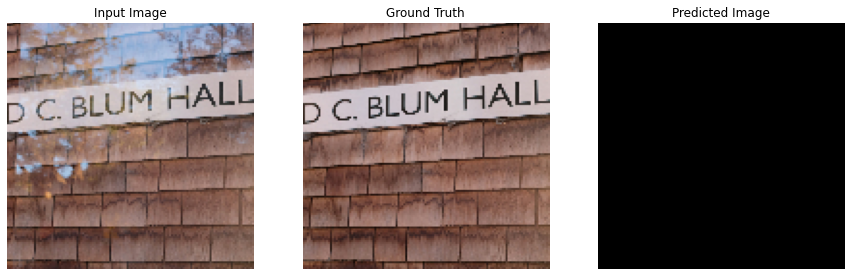

Epoch:  44
....................................................................................................
....................................................................................................
....................................................................................................
.........

KeyboardInterrupt: 

In [66]:
fit(train_dataset, EPOCHS, test_dataset, CKPT_SAVE)

------------------------------------------

Time taken for epoch 78 is 103.81446695327759 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


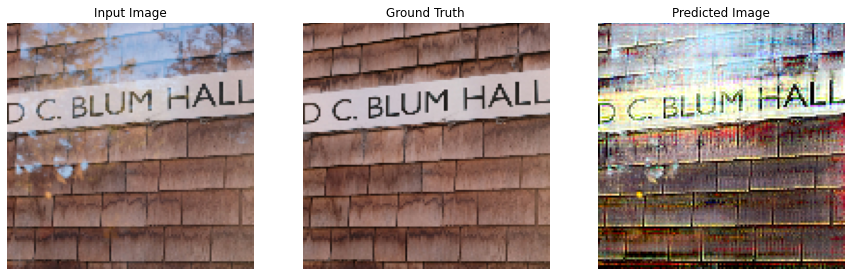

Epoch:  79
.

In [ ]:
## old result, training on real dataset only

# fit(train_dataset, EPOCHS, test_dataset)

## PREDICT

#### Load checkpoint:

In [54]:
!pwd

/home/jupyter/Tin-Final-Proj


--------------------------------------------------------------------
***(In case you need to change checkpoint directory)***

In [59]:
# checkpoint_dir = './logs/ckpts/ckpt_0612-2'
# checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

# checkpoint = tf.train.Checkpoint(epoch = tf.Variable(0),
#                                  generator_optimizer=generator_optimizer,
#                                  discriminator_optimizer=discriminator_optimizer,
#                                  generator=generator,
#                                  discriminator=discriminator)

In [60]:
# checkpoint_manager = tf.train.CheckpointManager(checkpoint= checkpoint,
#                                                 directory=checkpoint_dir,
#                                                 max_to_keep=5)

----------------------------------------------

In [67]:
checkpoint_manager.checkpoints

['./logs/ckpts/train/ckpt-11',
 './logs/ckpts/train/ckpt-12',
 './logs/ckpts/train/ckpt-13',
 './logs/ckpts/train/ckpt-14',
 './logs/ckpts/train/ckpt-15']

In [68]:
# LATEST CHECKPOINT
checkpoint.restore(checkpoint_manager.latest_checkpoint)

In [63]:
# OR CHOOSE ANOTHER CHECKPOINT
checkpoint.restore(checkpoint_manager.checkpoints[3])

In [69]:
# Checking which epoch it is:
checkpoint.epoch.numpy()

40

In [63]:
psnr_value = evaluate(checkpoint.generator, test_dataset)  
psnr_value

<tf.Tensor: shape=(), dtype=float32, numpy=11.784449>

#### Show images from test dataset:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


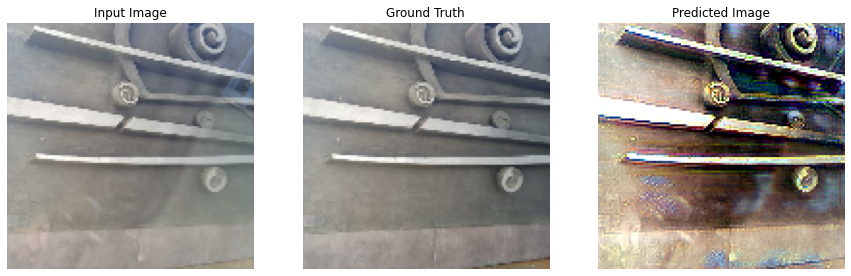

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


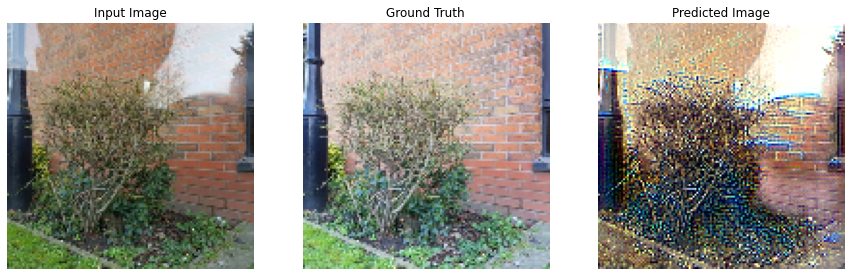

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


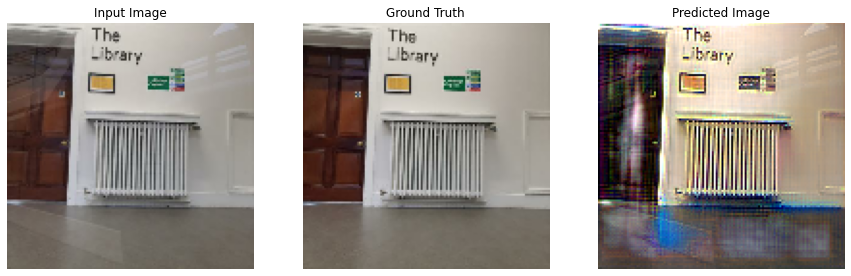

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


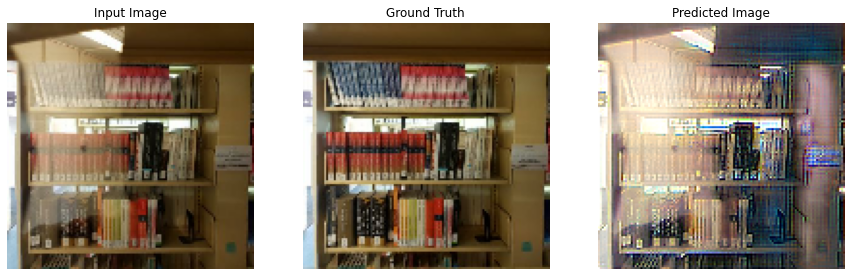

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


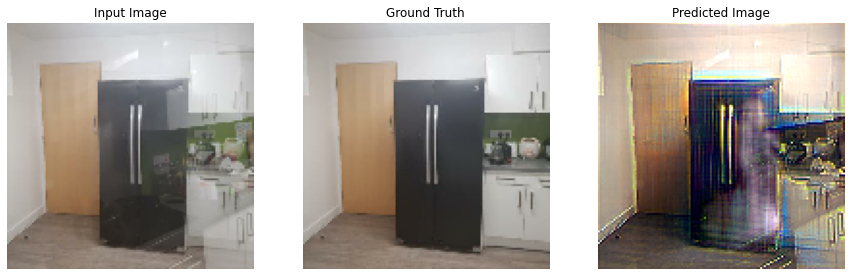

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


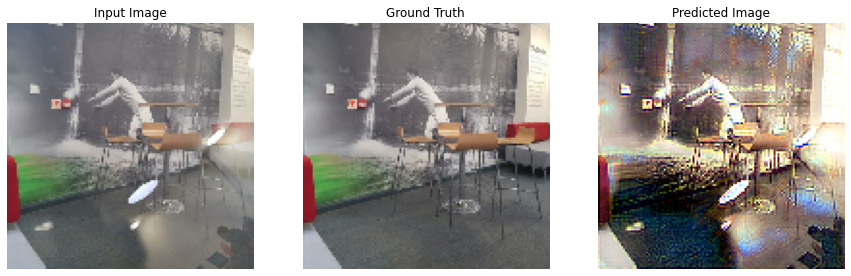

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


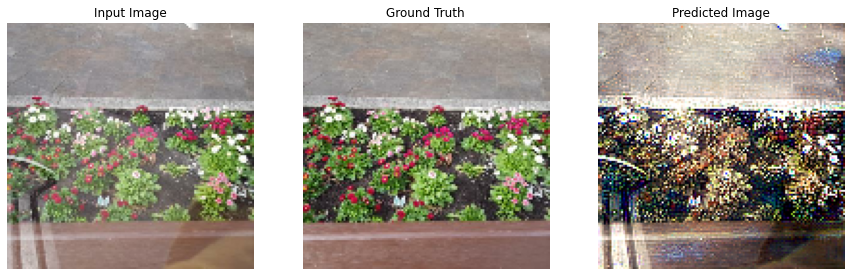

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


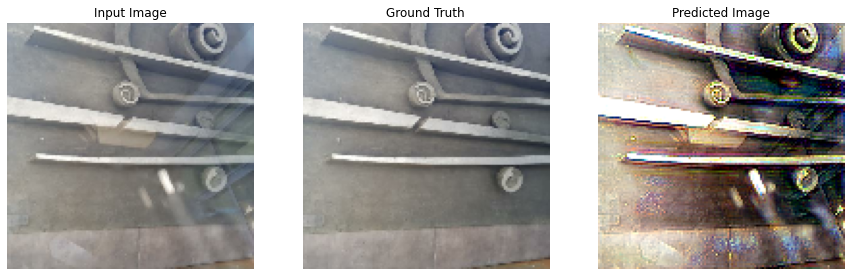

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


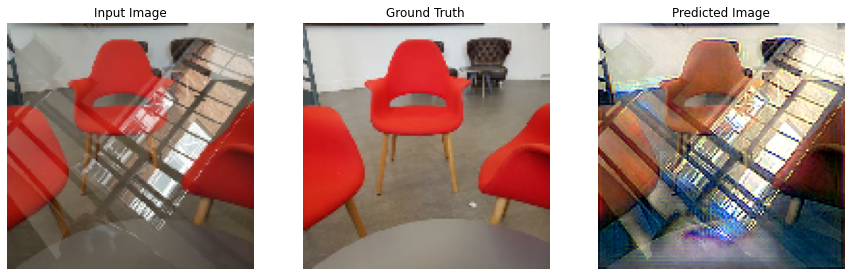

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


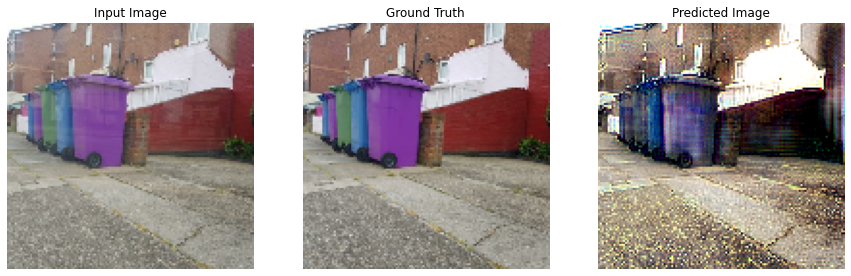

In [64]:
# for example_input, example_target in test_dataset.take(50):
#     generate_images(generator, example_input, example_target)
    
for example_input, _, example_target in train_dataset.take(10):
    generate_images(generator, example_input, example_target)
    
# for example_input, _, example_target, _ in train_syn_dataset.take(30):
#     generate_images(generator, example_input, example_target)